# Bowland North Predictive Model

This details the initial modeling of internal temperature of Bowland North. The dataset this analysis stems from (output/dataset.csv) has been processed from original EMS and BMS data files. Most of this preprocessing is captured by the python scripts in the root directory. However, some external manipulation to the intermediary files generated by the preprocessing scripts has been done in Tableau (the aggregation of electricity and heat consumption per hour, as well as the average in temperature readings per hour).

In [1]:
import pandas as pd
import numpy as np

# read the data
df = pd.read_csv('../output/dataset.csv')

# A little cleaning
df['ts'] = pd.to_datetime(df['ts'])
df['month'] = df['ts'].dt.month
df['hour'] = df['ts'].dt.hour
df = df.sort_values(by='ts')
df = df.iloc[:, 1:]
df = df[abs(df['INS'] - np.mean(df['INS'])) < 2 * np.std(df['INS'])] # removing outliers
df.head()

,ts,elec_consumption,heat_consumption,OAT,air_temp,concrete_temp,temp,is_weekend,is_term_day,INS,month,hour
0,2016-12-05 09:00:00,76,320,3.19,3.90,3.35,3.70,0,1,22.624,12,9
1,2016-12-05 10:00:00,85,278,3.92,4.58,4.40,4.38,0,1,22.145,12,10
2,2016-12-05 11:00:00,96,275,5.40,5.15,6.03,5.00,0,1,22.616,12,11
3,2016-12-05 12:00:00,101,265,7.59,5.90,7.35,5.79,0,1,23.061,12,12
4,2016-12-05 13:00:00,101,257,8.41,6.09,6.92,6.02,0,1,22.151,12,13


## EDA

### Internal Room Temperature vs. Time (Months)

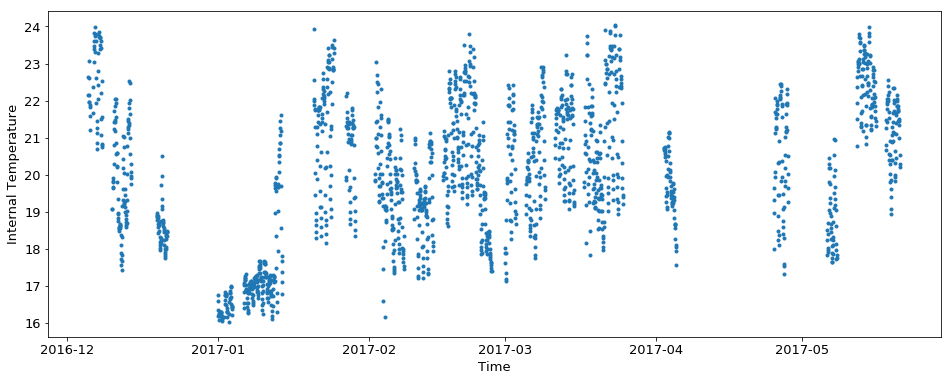

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = [16, 6]
plt.rcParams['font.size'] = 13
plt.xlabel("Time")
plt.ylabel("Internal Temperature")
# plt.title("Graph of Internal Temperature Variation over Time")
plt.plot('ts', 'INS', '.', data=df)
plt.savefig("../plots/ins_v_time.png")

plt.show()

### Electricity Consumption vs. Time (Months)

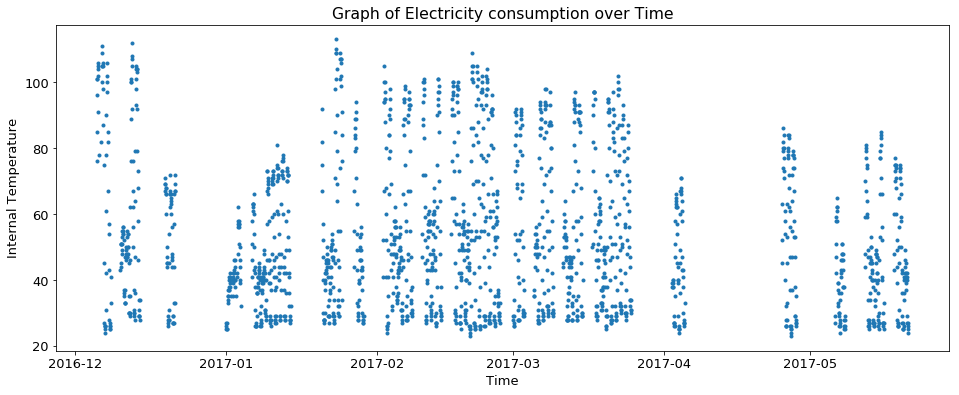

In [5]:
plt.rcParams["figure.figsize"] = [16, 6]
plt.xlabel("Time")
plt.ylabel("Internal Temperature")
plt.title("Graph of Electricity consumption over Time")
plt.plot('ts', 'elec_consumption', '.', data=df)
plt.savefig("../plots/elec_v_time.png")
plt.show()

### Heat Consumption vs. Time (Months)

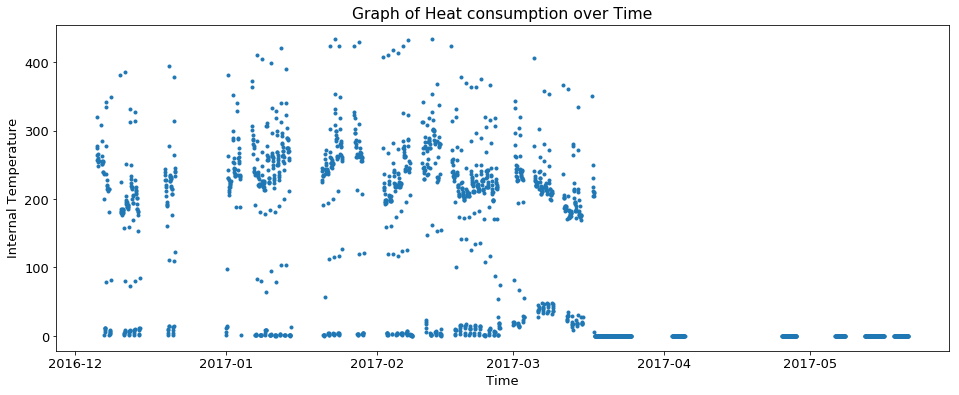

In [6]:
plt.rcParams["figure.figsize"] = [16, 6]
plt.xlabel("Time")
plt.ylabel("Internal Temperature")
plt.title("Graph of Heat consumption over Time")
plt.plot('ts', 'heat_consumption', '.', data=df)
plt.savefig("../plots/heat_v_time.png")
plt.show()

### X vs Y

Further exploring whether there is any significant collinearity to be aware of, between covariates and dependent variable.

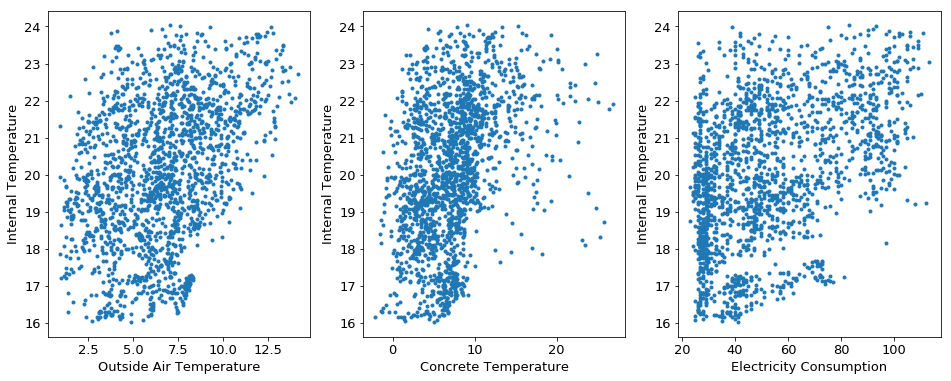

In [15]:
# plt.rcParams["figure.figsize"] = [7, 7]
plt.subplot(131) 
plt.xlabel("Outside Air Temperature")
plt.ylabel("Internal Temperature")
# plt.title("Outside Air Temperature vs Internal Temperature")
plt.plot('OAT', 'INS', '.', data=df)

plt.subplot(132)
# plt.rcParams["figure.figsize"] = [7, 6]
plt.xlabel("Concrete Temperature")
plt.ylabel("Internal Temperature")
# plt.title("Concrete Temperature vs Internal Temperature")
plt.plot('concrete_temp', 'INS', '.', data=df)

plt.subplot(133)
plt.xlabel("Electricity Consumption")
plt.ylabel("Internal Temperature")
# plt.title("Electricity consumption vs Internal Temperature")
plt.plot('elec_consumption', 'INS', '.', data=df)

plt.savefig("../plots/x_v_y_1.png")
plt.show()

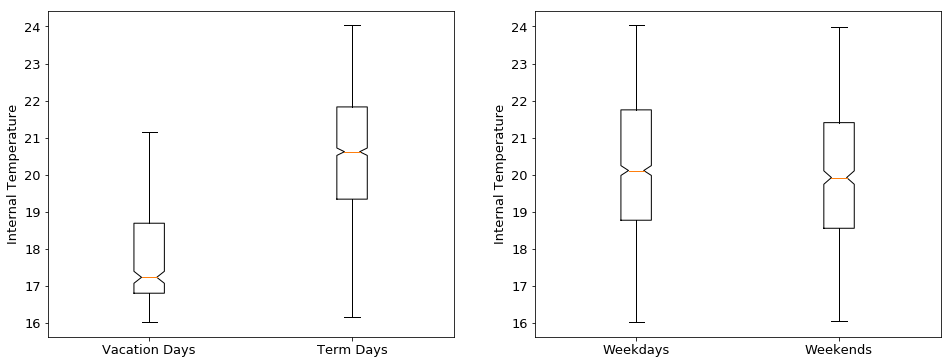

In [17]:
plt.subplot(121)
df_nt = df[df['is_term_day'] == 0]
df_t = df[df['is_term_day'] == 1]
df_box = [df_nt['INS'], df_t['INS']]

# plt.Axes.set_xticklabels()
plt.boxplot(df_box, labels=["Vacation Days", "Term Days"], notch=True)
plt.ylabel("Internal Temperature")
# plt.show()

plt.subplot(122)
df_nt = df[df['is_weekend'] == 0]
df_t = df[df['is_weekend'] == 1]
df_box = [df_nt['INS'], df_t['INS']]

# plt.Axes.set_xticklabels()
plt.boxplot(df_box, labels=["Weekdays", "Weekends"], notch=True)
plt.ylabel("Internal Temperature")
plt.savefig("../plots/x_v_y_2.png")
plt.show()

Observations:
* The data arenot indicative of a strong linear relationship. 
* Term Days / Vacation Days show a distinct difference in Internal Room Temperature.

## Day Patterns
### Internal Room Temperature over Term Day


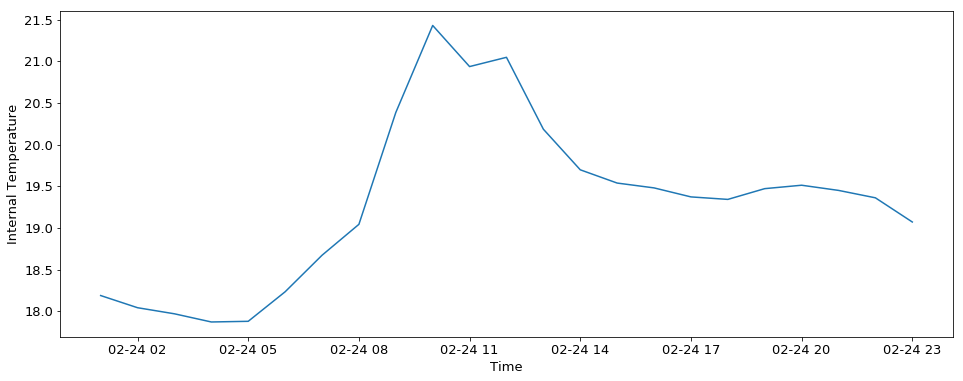

In [19]:
df_day = df[df['ts'] > pd.to_datetime('24/02/2017')] # a term day
df_day = df_day[df_day['ts'] < pd.to_datetime('25/02/2017')]

plt.rcParams["figure.figsize"] = [16, 6]
plt.xlabel("Time")
plt.ylabel("Internal Temperature")
# plt.title("Graph of Internal Temperature Variation over Time (Term Day)")
plt.plot('ts', 'INS', data=df_day)
plt.savefig("../plots/ins_v_day.png")
plt.show()

### Other Factors over Term Day

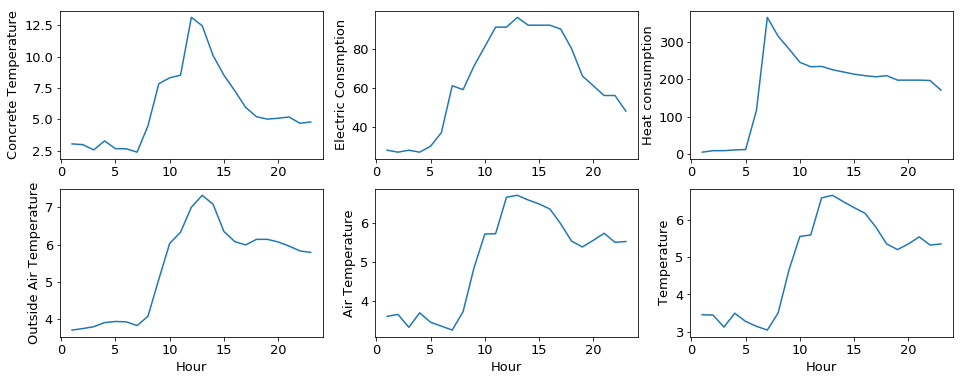

In [41]:
plt.subplot(231) 
# plt.xlabel("Hour")
plt.ylabel("Concrete Temperature")
# plt.xticks(rotation='vertical')
plt.plot('hour', 'concrete_temp', '-', data=df_day)

plt.subplot(232)
# plt.xlabel("Hour")
plt.ylabel("Electric Consmption")
# plt.xticks(rotation='vertical')
plt.plot('hour', 'elec_consumption', '-', data=df_day)

plt.subplot(233)
# plt.xlabel("Hour")
plt.ylabel("Heat consumption")
plt.plot('hour', 'heat_consumption', '-', data=df_day)

plt.subplot(234) 
plt.xlabel("Hour")
plt.ylabel("Outside Air Temperature")
plt.plot('hour', 'OAT', '-', data=df_day) # re look

plt.subplot(235)
plt.xlabel("Hour")
plt.ylabel("Air Temperature")
plt.plot('hour', 'air_temp', '-', data=df_day)

plt.subplot(236)
plt.xlabel("Hour")
plt.ylabel("Temperature")
plt.plot('hour', 'temp', '-', data=df_day)

plt.savefig("../plots/x_v_day.png")
plt.show()

### Internal Room Temperature over Multiple Days

This is better captured in the accompanying _Rplots.R_ file.

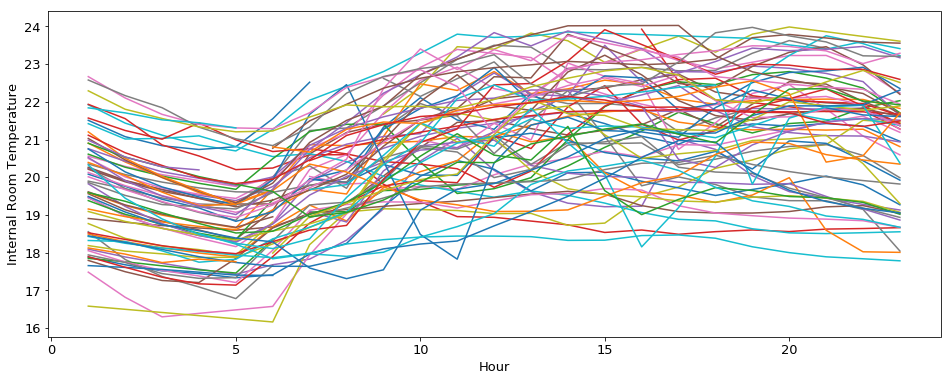

In [42]:
import datetime
from cycler import cycler
from matplotlib.colors import Colormap
from matplotlib.collections import LineCollection

# colors = {12 :'y-', 1:'b-', 2:'g-', 3:'r-', 4:'c-', 5:'m-'}
# df['colors'] = df['month'].map(colors)

df_term = df[df['is_term_day'] == 1]
cday = pd.to_datetime('05/12/2016')

# df_term.groupby('month').plot('hour', 'INS', title=title)
# df_term.to_csv("df_term.csv")

cday = pd.to_datetime('05/12/2016')
lines = 0
for _ in range(df_term.shape[0]):
    # select a day
    df_day = df_term[df_term['ts'] > cday]
    df_day = df_day[df_day['ts'] < cday + datetime.timedelta(days=1)]
    
    # plot INS readings per hour of selected day
    plt.plot(df_day['ts'].dt.hour, 'INS', data=df_day)
    cday += datetime.timedelta(days=1)

plt.ylabel("Internal Room Temperature")
plt.xlabel("Hour")
plt.savefig("../plots/insvdays.png")
plt.show()
#heat map gradient
# month gradient
# weekend distinction (--)

### Other Factors over Multiple Term Days

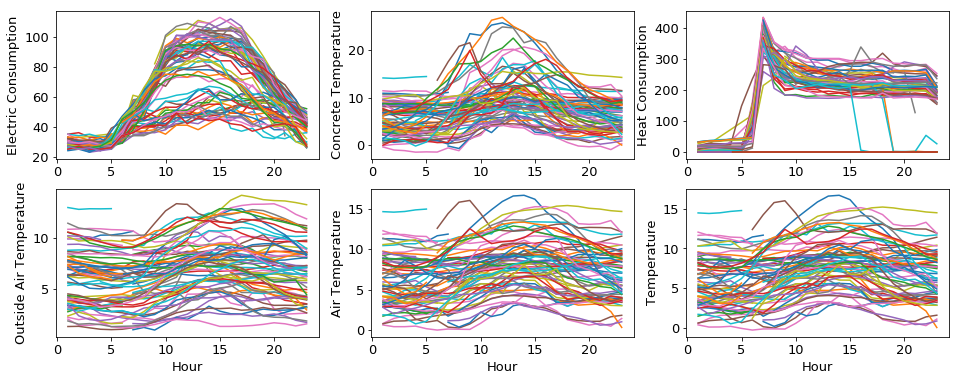

In [43]:
# elec_consumption
plt.subplot(231)
df_term = df[df['is_term_day'] == 1]
plt.rcParams["figure.figsize"] = [16, 6]
# plt.xlabel("Hour")
plt.ylabel("Electric Consumption")

cday = pd.to_datetime('05/12/2016')
lines = 0
for _ in range(df_term.shape[0]):
    df_day = df_term[df_term['ts'] > cday]
    df_day = df_day[df_day['ts'] < cday + datetime.timedelta(days=1)]
    
    plt.plot(df_day['ts'].dt.hour, 'elec_consumption', data=df_day)
    cday += datetime.timedelta(days=1)

# concrete temp
plt.subplot(232)
df_term = df[df['is_term_day'] == 1]
plt.rcParams["figure.figsize"] = [16, 6]
# plt.xlabel("Hour")
plt.ylabel("Concrete Temperature")

cday = pd.to_datetime('05/12/2016')
lines = 0
for _ in range(df_term.shape[0]):
    df_day = df_term[df_term['ts'] > cday]
    df_day = df_day[df_day['ts'] < cday + datetime.timedelta(days=1)]
    
    plt.plot(df_day['ts'].dt.hour, 'concrete_temp', data=df_day)
    cday += datetime.timedelta(days=1)

# heat_consumption
plt.subplot(233)
df_term = df[df['is_term_day'] == 1]
plt.rcParams["figure.figsize"] = [16, 6]
# plt.xlabel("Hour")
plt.ylabel("Heat Consumption")

cday = pd.to_datetime('05/12/2016')
lines = 0
for _ in range(df_term.shape[0]):
    df_day = df_term[df_term['ts'] > cday]
    df_day = df_day[df_day['ts'] < cday + datetime.timedelta(days=1)]
    
    plt.plot(df_day['ts'].dt.hour, 'heat_consumption', data=df_day)
    cday += datetime.timedelta(days=1)

# Outside Air Temperature
plt.subplot(234)
df_term = df[df['is_term_day'] == 1]
plt.rcParams["figure.figsize"] = [16, 6]
plt.xlabel("Hour")
plt.ylabel("Outside Air Temperature")

cday = pd.to_datetime('05/12/2016')
lines = 0
for _ in range(df_term.shape[0]):
    df_day = df_term[df_term['ts'] > cday]
    df_day = df_day[df_day['ts'] < cday + datetime.timedelta(days=1)]
    
    plt.plot(df_day['ts'].dt.hour, 'OAT', data=df_day)
    cday += datetime.timedelta(days=1)
    
# Air Temperature
plt.subplot(235)
df_term = df[df['is_term_day'] == 1]
plt.rcParams["figure.figsize"] = [16, 6]
plt.xlabel("Hour")
plt.ylabel("Air Temperature")

cday = pd.to_datetime('05/12/2016')
lines = 0
for _ in range(df_term.shape[0]):
    df_day = df_term[df_term['ts'] > cday]
    df_day = df_day[df_day['ts'] < cday + datetime.timedelta(days=1)]
    
    plt.plot(df_day['ts'].dt.hour, 'air_temp', data=df_day)
    cday += datetime.timedelta(days=1)

# Temperature
plt.subplot(236)
df_term = df[df['is_term_day'] == 1]
plt.rcParams["figure.figsize"] = [16, 6]
plt.xlabel("Hour")
plt.ylabel("Temperature")

cday = pd.to_datetime('05/12/2016')
lines = 0
for _ in range(df_term.shape[0]):
    df_day = df_term[df_term['ts'] > cday]
    df_day = df_day[df_day['ts'] < cday + datetime.timedelta(days=1)]
    
    plt.plot(df_day['ts'].dt.hour, 'temp', data=df_day)
    cday += datetime.timedelta(days=1)

plt.savefig("../plots/x_v_days.png")
plt.show()

### Internal Room Temperature over Non-Term Day

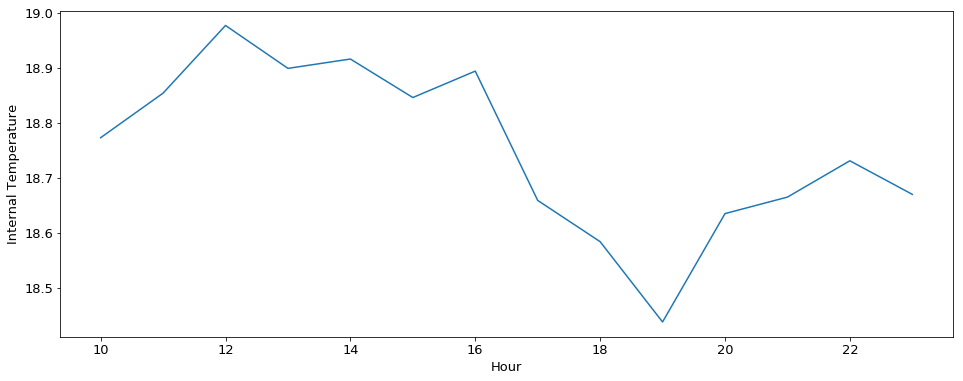

In [46]:
df_day = df[df['ts'] > pd.to_datetime('19/12/2016')] # a non-term day
df_day = df_day[df_day['ts'] < pd.to_datetime('20/12/2016')]

plt.rcParams["figure.figsize"] = [16, 6]
plt.xlabel("Hour")
plt.ylabel("Internal Temperature")
# plt.title("Graph of Internal Temperature Variation over Time (Non-Term Day)")
plt.plot('hour', 'INS', '-' , data=df_day)
plt.savefig("../plots/ins_v_ntday.png")
plt.show()

### Other Factors over Non-Term Day

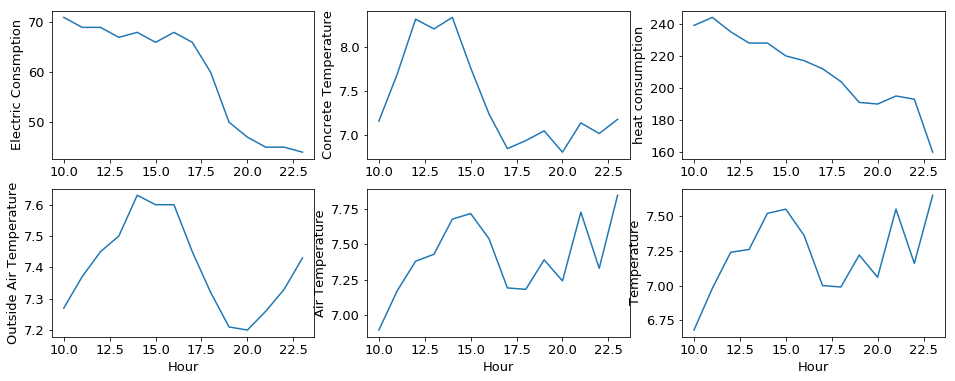

In [48]:
plt.subplot(231) 
# plt.xlabel("time")
plt.ylabel("Electric Consmption")
plt.plot('hour', 'elec_consumption', '-', data=df_day)

plt.subplot(232)
# plt.xlabel("time")
plt.ylabel("Concrete Temperature")
plt.plot('hour', 'concrete_temp', '-', data=df_day)

plt.subplot(233)
# plt.xlabel("time")
plt.ylabel("heat consumption")
plt.plot('hour', 'heat_consumption', '-', data=df_day)

plt.subplot(234) 
plt.xlabel("Hour")
plt.ylabel("Outside Air Temperature")
plt.plot('hour', 'OAT', '-', data=df_day)

plt.subplot(235)
plt.xlabel("Hour")
plt.ylabel("Air Temperature")
plt.plot('hour', 'air_temp', '-', data=df_day)

plt.subplot(236)
plt.xlabel("Hour")
plt.ylabel("Temperature")
plt.plot('hour', 'temp', '-', data=df_day)

plt.savefig("../plots/x_v_ntday.png")
plt.show()

### Internal Room Temperature over Multiple Non-Term Days

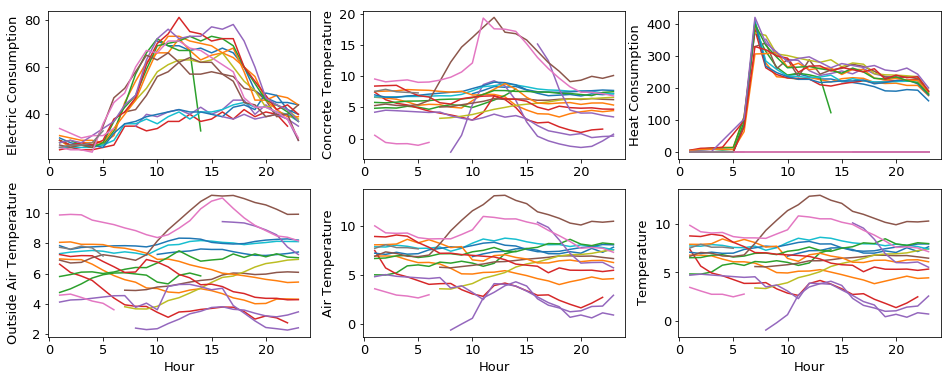

In [49]:
# elec_consumption
plt.subplot(231)
df_term = df[df['is_term_day'] == 0]
plt.rcParams["figure.figsize"] = [16, 6]
# plt.xlabel("Hour")
plt.ylabel("Electric Consumption")

cday = pd.to_datetime('19/12/2016')
lines = 0
for _ in range(df_term.shape[0]):
    df_day = df_term[df_term['ts'] > cday]
    df_day = df_day[df_day['ts'] < cday + datetime.timedelta(days=1)]
    
    plt.plot(df_day['ts'].dt.hour, 'elec_consumption', data=df_day)
    cday += datetime.timedelta(days=1)

# concrete temp
plt.subplot(232)
df_term = df[df['is_term_day'] == 0]
plt.rcParams["figure.figsize"] = [16, 6]
# plt.xlabel("Hour")
plt.ylabel("Concrete Temperature")

cday = pd.to_datetime('19/12/2016')
lines = 0
for _ in range(df_term.shape[0]):
    df_day = df_term[df_term['ts'] > cday]
    df_day = df_day[df_day['ts'] < cday + datetime.timedelta(days=1)]
    
    plt.plot(df_day['ts'].dt.hour, 'concrete_temp', data=df_day)
    cday += datetime.timedelta(days=1)

# heat_consumption
plt.subplot(233)
df_term = df[df['is_term_day'] == 0]
plt.rcParams["figure.figsize"] = [16, 6]
# plt.xlabel("Hour")
plt.ylabel("Heat Consumption")

cday = pd.to_datetime('19/12/2016')
lines = 0
for _ in range(df_term.shape[0]):
    df_day = df_term[df_term['ts'] > cday]
    df_day = df_day[df_day['ts'] < cday + datetime.timedelta(days=1)]
    
    plt.plot(df_day['ts'].dt.hour, 'heat_consumption', data=df_day)
    cday += datetime.timedelta(days=1)

# Outside Air Temperature
plt.subplot(234)
df_term = df[df['is_term_day'] == 0]
plt.rcParams["figure.figsize"] = [16, 6]
plt.xlabel("Hour")
plt.ylabel("Outside Air Temperature")

cday = pd.to_datetime('19/12/2016')
lines = 0
for _ in range(df_term.shape[0]):
    df_day = df_term[df_term['ts'] > cday]
    df_day = df_day[df_day['ts'] < cday + datetime.timedelta(days=1)]
    
    plt.plot(df_day['ts'].dt.hour, 'OAT', data=df_day)
    cday += datetime.timedelta(days=1)
    
# Air Temperature
plt.subplot(235)
df_term = df[df['is_term_day'] == 0]
plt.rcParams["figure.figsize"] = [16, 6]
plt.xlabel("Hour")
plt.ylabel("Air Temperature")

cday = pd.to_datetime('19/12/2016')
lines = 0
for _ in range(df_term.shape[0]):
    df_day = df_term[df_term['ts'] > cday]
    df_day = df_day[df_day['ts'] < cday + datetime.timedelta(days=1)]
    
    plt.plot(df_day['ts'].dt.hour, 'air_temp', data=df_day)
    cday += datetime.timedelta(days=1)

# Temperature
plt.subplot(236)
df_term = df[df['is_term_day'] == 0]
plt.rcParams["figure.figsize"] = [16, 6]
plt.xlabel("Hour")
plt.ylabel("Temperature")

cday = pd.to_datetime('19/12/2016')
lines = 0
for _ in range(df_term.shape[0]):
    df_day = df_term[df_term['ts'] > cday]
    df_day = df_day[df_day['ts'] < cday + datetime.timedelta(days=1)]
    
    plt.plot(df_day['ts'].dt.hour, 'temp', data=df_day)
    cday += datetime.timedelta(days=1)

plt.savefig("../plots/x_v_ntdays.png")
plt.show()

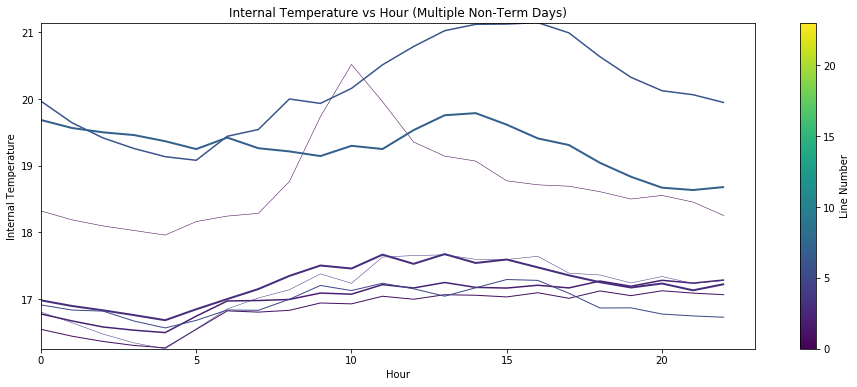

In [13]:
df_term = df[df['is_term_day'] == 0]
plt.rcParams["figure.figsize"] = [16, 6]

x = np.arange(24) # for each of the 24 hours on the x-axis
ys = []
cday = pd.to_datetime('19/12/2016')

df_term.to_csv("df_nonterm.csv")

for _ in range(df_term.shape[0]):
    # select a day
    df_day = df_term[df_term['ts'] > cday]
    df_day = df_day[df_day['ts'] < cday + datetime.timedelta(days=1)]
    
    # plot INS readings per hour of selected day
    if  len(df_day['INS'].values) > 22: # picking only days with complete readings
        ys.append(df_day['INS'].values)
    cday += datetime.timedelta(days=1)

fig, ax = plt.subplots()
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys), np.max(ys))

line_segments = LineCollection([list(zip(x, y)) for y in ys],
                               linewidths=(0.5, 1, 1.5, 2),
                               linestyles='solid')
line_segments.set_array(x)
ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Line Number')
ax.set_title('Internal Temperature vs Hour (Multiple Non-Term Days)')
plt.sci(line_segments)
plt.xlabel("Hour")
plt.ylabel("Internal Temperature")
plt.show()


### Other Factors over Multiple Non-Term Days

##### Electric Consumption Vs Time (Non-Term)

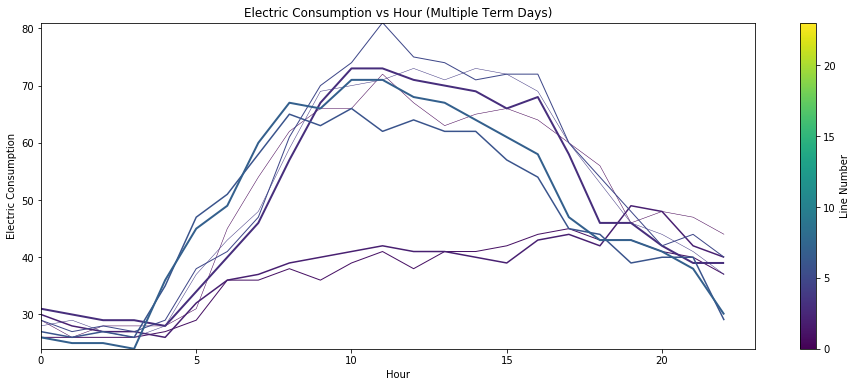

In [14]:
df_term = df[df['is_term_day'] == 0]
plt.rcParams["figure.figsize"] = [16, 6]

x = np.arange(24) # for each of the 24 hours on the x-axis
ys = []
cday = pd.to_datetime('19/12/2016')

for _ in range(df_term.shape[0]):
    # select a day
    df_day = df_term[df_term['ts'] > cday]
    df_day = df_day[df_day['ts'] < cday + datetime.timedelta(days=1)]
    
    # plot INS readings per hour of selected day
    if  len(df_day['elec_consumption'].values) > 22: # picking only days with complete readings
        ys.append(df_day['elec_consumption'].values)
    cday += datetime.timedelta(days=1)

fig, ax = plt.subplots()
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys), np.max(ys))

line_segments = LineCollection([list(zip(x, y)) for y in ys],
                               linewidths=(0.5, 1, 1.5, 2),
                               linestyles='solid')
line_segments.set_array(x)
ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Line Number')
ax.set_title('Electric Consumption vs Hour (Multiple Term Days)')
plt.sci(line_segments)
plt.xlabel("Hour")
plt.ylabel("Electric Consumption")
plt.show()

##### Heat Consumption vs. Time (Non-Term)

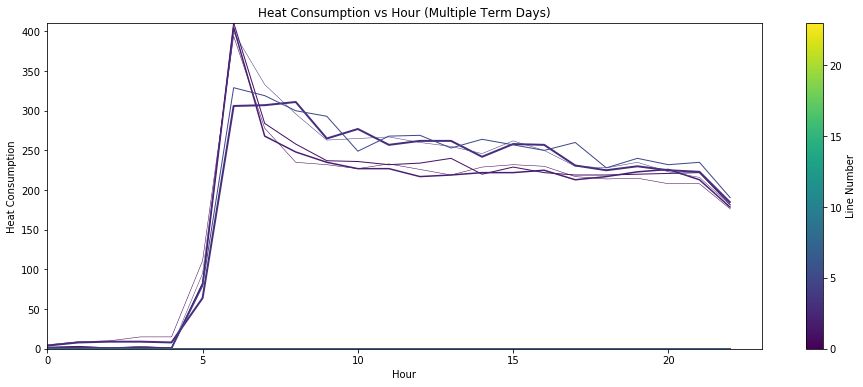

In [15]:
df_term = df[df['is_term_day'] == 0]
plt.rcParams["figure.figsize"] = [16, 6]

x = np.arange(24) # for each of the 24 hours on the x-axis
ys = []
cday = pd.to_datetime('19/12/2016')

for _ in range(df_term.shape[0]):
    # select a day
    df_day = df_term[df_term['ts'] > cday]
    df_day = df_day[df_day['ts'] < cday + datetime.timedelta(days=1)]
    
    # plot INS readings per hour of selected day
    if  len(df_day['elec_consumption'].values) > 22: # picking only days with complete readings
        ys.append(df_day['heat_consumption'].values)
    cday += datetime.timedelta(days=1)

fig, ax = plt.subplots()
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys), np.max(ys))

line_segments = LineCollection([list(zip(x, y)) for y in ys],
                               linewidths=(0.5, 1, 1.5, 2),
                               linestyles='solid')
line_segments.set_array(x)
ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Line Number')
ax.set_title('Heat Consumption vs Hour (Multiple Term Days)')
plt.sci(line_segments)
plt.xlabel("Hour")
plt.ylabel("Heat Consumption")
plt.show()

##### Concrete Temperature vs. Time (Non-Term)

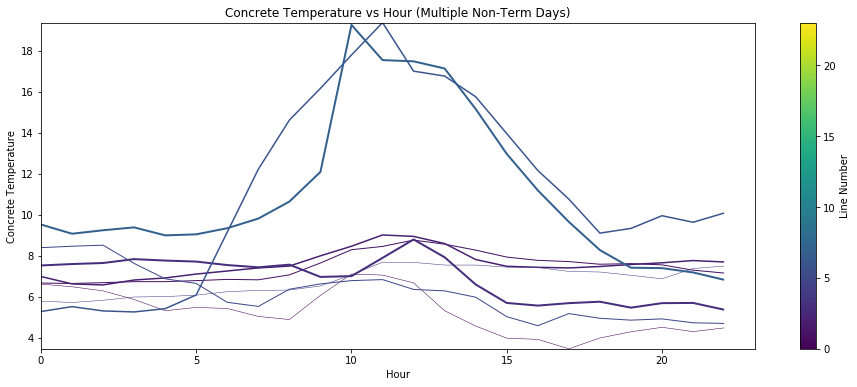

In [16]:
df_term = df[df['is_term_day'] == 0]
plt.rcParams["figure.figsize"] = [16, 6]

x = np.arange(24) # for each of the 24 hours on the x-axis
ys = []
cday = pd.to_datetime('19/12/2016')

for _ in range(df_term.shape[0]):
    # select a day
    df_day = df_term[df_term['ts'] > cday]
    df_day = df_day[df_day['ts'] < cday + datetime.timedelta(days=1)]
    
    # plot INS readings per hour of selected day
    if  len(df_day['elec_consumption'].values) > 22: # picking only days with complete readings
        ys.append(df_day['concrete_temp'].values)
    cday += datetime.timedelta(days=1)

fig, ax = plt.subplots()
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys), np.max(ys))

line_segments = LineCollection([list(zip(x, y)) for y in ys],
                               linewidths=(0.5, 1, 1.5, 2),
                               linestyles='solid')
line_segments.set_array(x)
ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Line Number')
ax.set_title('Concrete Temperature vs Hour (Multiple Non-Term Days)')
plt.sci(line_segments)
plt.xlabel("Hour")
plt.ylabel("Concrete Temperature")
plt.show()

##### Outside Air Temperature vs. Time (Non-Term)

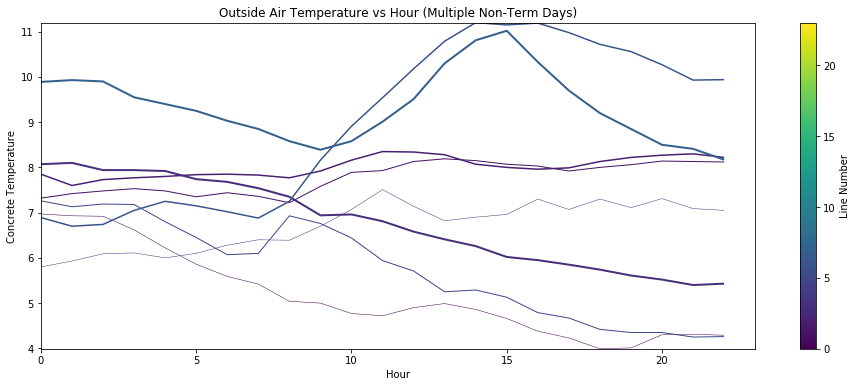

In [17]:
df_term = df[df['is_term_day'] == 0]
plt.rcParams["figure.figsize"] = [16, 6]

x = np.arange(24) # for each of the 24 hours on the x-axis
ys = []
cday = pd.to_datetime('19/12/2016')

for _ in range(df_term.shape[0]):
    # select a day
    df_day = df_term[df_term['ts'] > cday]
    df_day = df_day[df_day['ts'] < cday + datetime.timedelta(days=1)]
    
    # plot INS readings per hour of selected day
    if  len(df_day['elec_consumption'].values) > 22: # picking only days with complete readings
        ys.append(df_day['OAT'].values)
    cday += datetime.timedelta(days=1)

fig, ax = plt.subplots()
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys), np.max(ys))

line_segments = LineCollection([list(zip(x, y)) for y in ys],
                               linewidths=(0.5, 1, 1.5, 2),
                               linestyles='solid')
line_segments.set_array(x)
ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Line Number')
ax.set_title('Outside Air Temperature vs Hour (Multiple Non-Term Days)')
plt.sci(line_segments)
plt.xlabel("Hour")
plt.ylabel("Concrete Temperature")
plt.show()

##### Air Temperature vs. Time (Non-Term)

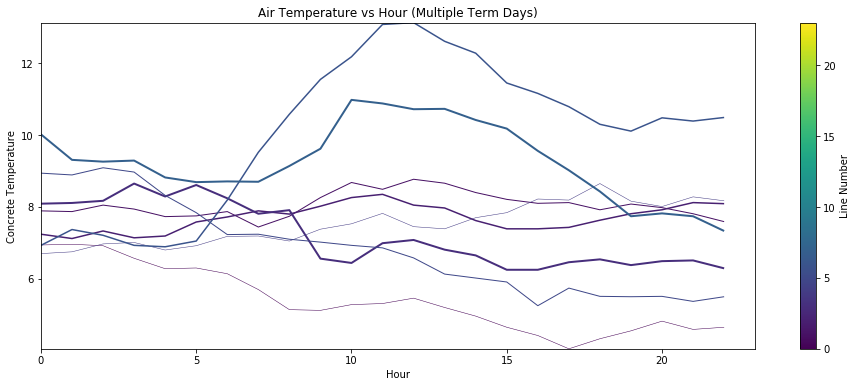

In [18]:
df_term = df[df['is_term_day'] == 0]
plt.rcParams["figure.figsize"] = [16, 6]

x = np.arange(24) # for each of the 24 hours on the x-axis
ys = []
cday = pd.to_datetime('19/12/2016')

for _ in range(df_term.shape[0]):
    # select a day
    df_day = df_term[df_term['ts'] > cday]
    df_day = df_day[df_day['ts'] < cday + datetime.timedelta(days=1)]
    
    # plot INS readings per hour of selected day
    if  len(df_day['elec_consumption'].values) > 22: # picking only days with complete readings
        ys.append(df_day['air_temp'].values)
    cday += datetime.timedelta(days=1)

fig, ax = plt.subplots()
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys), np.max(ys))

line_segments = LineCollection([list(zip(x, y)) for y in ys],
                               linewidths=(0.5, 1, 1.5, 2),
                               linestyles='solid')
line_segments.set_array(x)
ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Line Number')
ax.set_title('Air Temperature vs Hour (Multiple Term Days)')
plt.sci(line_segments)
plt.xlabel("Hour")
plt.ylabel("Concrete Temperature")
plt.show()

##### Temperature vs. Time (Non-Term)

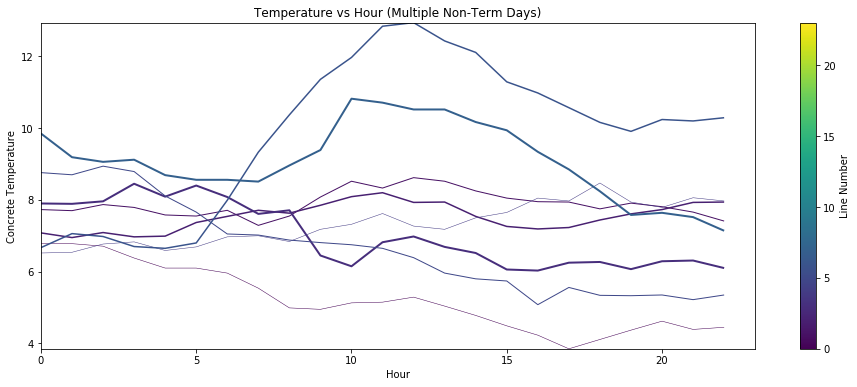

In [19]:
df_term = df[df['is_term_day'] == 0]
plt.rcParams["figure.figsize"] = [16, 6]

x = np.arange(24) # for each of the 24 hours on the x-axis
ys = []
cday = pd.to_datetime('19/12/2016')

for _ in range(df_term.shape[0]):
    # select a day
    df_day = df_term[df_term['ts'] > cday]
    df_day = df_day[df_day['ts'] < cday + datetime.timedelta(days=1)]
    
    # plot INS readings per hour of selected day
    if  len(df_day['elec_consumption'].values) > 22: # picking only days with complete readings
        ys.append(df_day['temp'].values)
    cday += datetime.timedelta(days=1)

fig, ax = plt.subplots()
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys), np.max(ys))

line_segments = LineCollection([list(zip(x, y)) for y in ys],
                               linewidths=(0.5, 1, 1.5, 2),
                               linestyles='solid')
line_segments.set_array(x)
ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Line Number')
ax.set_title('Temperature vs Hour (Multiple Non-Term Days)')
plt.sci(line_segments)
plt.xlabel("Hour")
plt.ylabel("Concrete Temperature")
plt.show()

Air Temperature, Outside Air Temperature and Temperature all look about the same. One alone will be sufficient as a predictor variable, if any must be used.

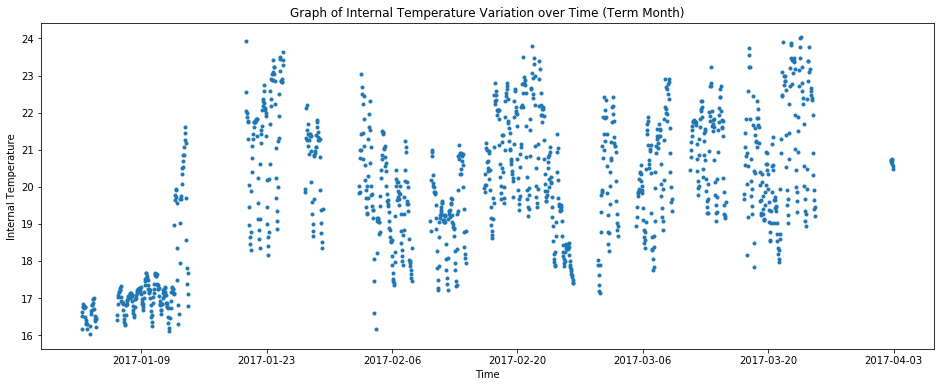

In [20]:
df_mth = df[df['ts'] > pd.to_datetime('01/02/2017')] # a term month
df_mth = df_mth[df_mth['ts'] < pd.to_datetime('04/03/2017')]

plt.rcParams["figure.figsize"] = [16, 6]
plt.xlabel("Time")
plt.ylabel("Internal Temperature")
plt.title("Graph of Internal Temperature Variation over Time (Term Month)")
plt.plot('ts', 'INS', '.', data=df_mth)
plt.show()

Note: It may be good to add a measure of distance from term start date.

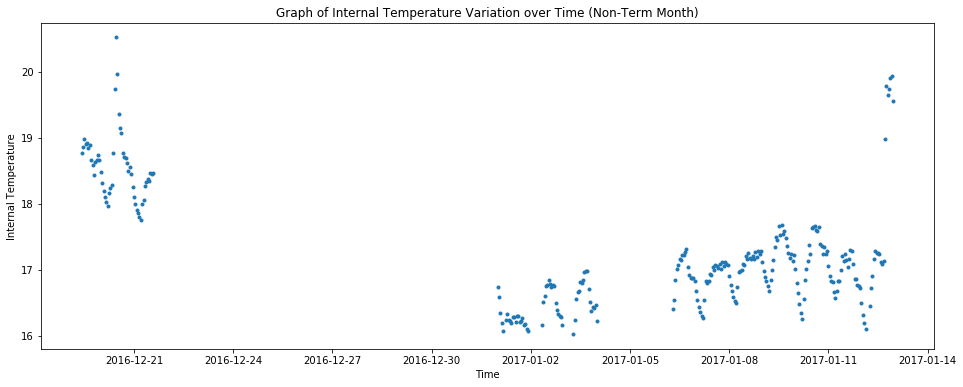

In [21]:
df_mth = df[df['ts'] > pd.to_datetime('19/12/2016')] # a non-term month
df_mth = df_mth[df_mth['ts'] < pd.to_datetime('13/01/2017')]

plt.rcParams["figure.figsize"] = [16, 6]
plt.xlabel("Time")
plt.ylabel("Internal Temperature")
plt.title("Graph of Internal Temperature Variation over Time (Non-Term Month)")
plt.plot('ts', 'INS','.', data=df_mth)
plt.show()

## Feature Correlation
Examining the features in a little more detail below to see if anything could be removed as a result of very high correlation.

In [22]:
df.corr()

,elec_consumption,heat_consumption,OAT,air_temp,concrete_temp,temp,is_weekend,is_term_day,INS,month,hour
elec_consumption,1.000000,0.458263,0.061209,0.122143,0.238512,0.125783,-0.352478,0.148256,0.436973,0.055328,0.436057
heat_consumption,0.458263,1.000000,-0.293388,-0.290222,-0.264176,-0.288738,-0.046432,-0.108221,-0.015824,-0.110591,0.364397
OAT,0.061209,-0.293388,1.000000,0.917564,0.779174,0.916193,0.056181,0.031275,0.376236,0.388573,0.133459
air_temp,0.122143,-0.290222,0.917564,1.000000,0.898808,0.999846,0.040586,0.059599,0.371168,0.344420,0.096925
concrete_temp,0.238512,-0.264176,0.779174,0.898808,1.000000,0.902654,0.029665,0.089373,0.369649,0.248429,0.097782
temp,0.125783,-0.288738,0.916193,0.999846,0.902654,1.000000,0.040972,0.060108,0.371362,0.344481,0.097223
is_weekend,-0.352478,-0.046432,0.056181,0.040586,0.029665,0.040972,1.000000,0.077419,-0.074054,-0.083696,-0.002250
is_term_day,0.148256,-0.108221,0.031275,0.059599,0.089373,0.060108,0.077419,1.000000,0.570417,0.041395,-0.022806
INS,0.436973,-0.015824,0.376236,0.371168,0.369649,0.371362,-0.074054,0.570417,1.000000,0.171593,0.309257
month,0.055328,-0.110591,0.388573,0.344420,0.248429,0.344481,-0.083696,0.041395,0.171593,1.000000,-0.012197


As intuitively expected, the MET station temperature readings show high correlation with the outside air temperature readings of the Bowland North sensors.
The highly correlated fields will be removed to keep the regression model coefficients "sane".

In [50]:
# time splits 3hrs
# df['tz_1'] = (df['hour'] < 3) * 1
# df['tz_2'] = ((3 < df['hour']) & (df['hour'] <= 6)) * 1
# df['tz_3'] = ((6 < df['hour']) & (df['hour'] <= 9)) * 1
# df['tz_4'] = ((9 < df['hour']) & (df['hour'] <= 12)) * 1
# df['tz_5'] = ((12 < df['hour']) & (df['hour'] <= 15))* 1
# df['tz_6'] = ((15 < df['hour']) & (df['hour'] <= 18)) * 1
# df['tz_7'] = ((18 < df['hour']) & (df['hour'] <= 21)) * 1
# df['tz_8'] = (21 < df['hour']) * 1

# # time splits 2hrs
# df['tz_1'] = (df['hour'] < 2) * 1
# df['tz_2'] = ((2 < df['hour']) & (df['hour'] <= 4)) * 1
# df['tz_3'] = ((4 < df['hour']) & (df['hour'] <= 6)) * 1
# df['tz_4'] = ((6 < df['hour']) & (df['hour'] <= 8)) * 1
# df['tz_5'] = ((8 < df['hour']) & (df['hour'] <= 10))* 1
# df['tz_6'] = ((10 < df['hour']) & (df['hour'] <= 12)) * 1
# df['tz_7'] = ((12 < df['hour']) & (df['hour'] <= 14)) * 1
# df['tz_8'] = ((14 < df['hour']) & (df['hour'] <= 16)) * 1
# df['tz_9'] = ((16 < df['hour']) & (df['hour'] <= 18)) * 1
# df['tz_10'] = ((18 < df['hour']) & (df['hour'] <= 20)) * 1
# df['tz_11'] = ((20 < df['hour']) & (df['hour'] <= 22)) * 1
# df['tz_12'] = (22 < df['hour']) * 1

df['tz_1'] = (df['hour'] < 1) * 1
df['tz_2'] = ((1 < df['hour']) & (df['hour'] <= 2)) * 1
df['tz_3'] = ((2 < df['hour']) & (df['hour'] <= 3)) * 1
df['tz_4'] = ((3 < df['hour']) & (df['hour'] <= 4)) * 1
df['tz_5'] = ((4 < df['hour']) & (df['hour'] <= 5))* 1
df['tz_6'] = ((5 < df['hour']) & (df['hour'] <= 6))* 1
df['tz_7'] = ((6 < df['hour']) & (df['hour'] <= 7)) * 1
df['tz_8'] = ((7 < df['hour']) & (df['hour'] <= 8)) * 1
df['tz_9'] = ((8 < df['hour']) & (df['hour'] <= 9)) * 1
df['tz_10'] = ((9 < df['hour']) & (df['hour'] <= 10)) * 1
df['tz_11'] = ((10 < df['hour']) & (df['hour'] <= 11)) * 1
df['tz_12'] = ((11 < df['hour']) & (df['hour'] <= 12)) * 1
df['tz_13'] = ((12 < df['hour']) & (df['hour'] <= 13)) * 1
df['tz_14'] = ((13 < df['hour']) & (df['hour'] <= 14)) * 1
df['tz_15'] = ((14 < df['hour']) & (df['hour'] <= 15)) * 1
df['tz_16'] = ((15 < df['hour']) & (df['hour'] <= 16))* 1
df['tz_17'] = ((16 < df['hour']) & (df['hour'] <= 17)) * 1
df['tz_18'] = ((17 < df['hour']) & (df['hour'] <= 18)) * 1
df['tz_19'] = ((18 < df['hour']) & (df['hour'] <= 19)) * 1
df['tz_20'] = ((19 < df['hour']) & (df['hour'] <= 20)) * 1
df['tz_21'] = ((20 < df['hour']) & (df['hour'] <= 21)) * 1
df['tz_22'] = ((21 < df['hour']) & (df['hour'] <= 22)) * 1
df['tz_23'] = ((22 < df['hour']) & (df['hour'] <= 23)) * 1
df['tz_24'] = (23 < df['hour']) * 1

print("done")

done


In [51]:
# removing air temp and temp and concrete_temp
df = df[['ts','elec_consumption','heat_consumption', 'OAT','is_term_day', 'tz_1', 'tz_2' , 'tz_3', 
         'tz_4', 'tz_5','tz_6','tz_7','tz_8', 'tz_9', 'tz_10', 'tz_11', 'tz_12', 'tz_13', 'tz_14', 'tz_15', 
         'tz_16', 'tz_17','tz_18','tz_19','tz_20', 'tz_21', 'tz_22', 'tz_23','INS']] # - tz_24

In [25]:
# df.to_csv("bn.csv")

### Notes

It is clear that the relationship between the predictor variables and internal room temperature(INS), do not have a a strong linear relationship. As a result, a general additive model is explored with each coefficient treated as a function of time.

## Modeling

#### Data Preparation

In [52]:
df2 = df # run on full set of features

df_train = df2[df2['ts'].dt.month <= 3]
df_test = df2[df2['ts'].dt.month > 3] 

# df_train = df2[(df2['ts'].dt.month < 3) & (df2['ts'].dt.month == 12)]
# df_test = df2[df2['ts'].dt.month >= 3] 

X_train = df_train.iloc[:,1:-1]
y_train = df_train.iloc[:,-1]

X_test = df_test.iloc[:,1:-1]
y_test = df_test.iloc[:,-1]

### Linear Regression

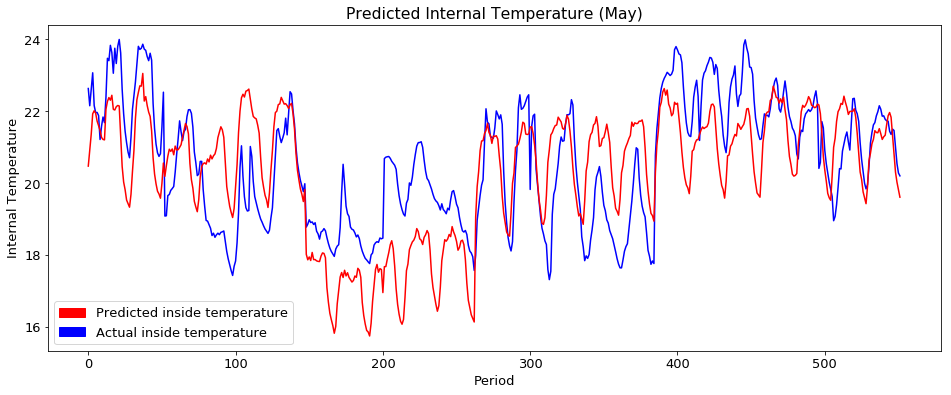

Regression Score: 0.23


In [53]:
from sklearn.linear_model import LinearRegression
import matplotlib.patches as mpatches

linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

x_period = np.arange(len(df_train['ts']))

# testing it on unseen data
x_period_test = np.arange(len(df_test['ts']))

#- plt.plot(x_period_test, y_test, 'b-', x_period_test, linear_regression.predict(poly_regression.fit_transform(X_test)), 'r-') # actual internal temp readings in blue
plt.plot(x_period_test, y_test, 'b-', x_period_test, linear_regression.predict(X_test), 'r-')
plt.title("Predicted Internal Temperature (May)")
plt.ylabel("Internal Temperature")
plt.xlabel("Period")
red_patch = mpatches.Patch(color='red', label='Predicted inside temperature')
blue_patch = mpatches.Patch(color='blue', label='Actual inside temperature')
plt.legend(handles=[red_patch, blue_patch])
plt.savefig("../plots/linear_results.png")
plt.show()

print("Regression Score: %.2f" % linear_regression.score(X_test, y_test))

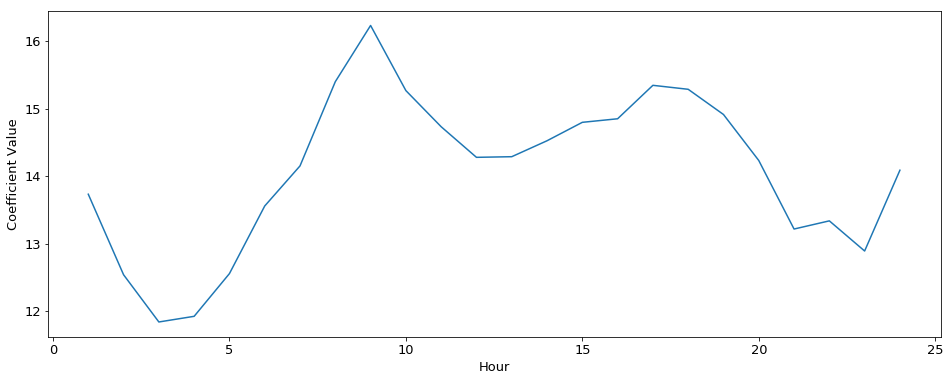

In [54]:
i_df = pd.read_csv("../metadata/intercepts.csv")
# i_df = i_df.iloc[:,1]
i_df.columns = ['hour', 'coef']

plt.ylabel('Coefficient Value')
plt.xlabel('Hour')
plt.plot('hour', 'coef', data=i_df)
plt.savefig('../plots/intercepts.png')
plt.show()

### GAM

In [55]:
df2 = df # run on full set of features

df_train = df2[df2['ts'].dt.month <= 3]
df_test = df2[df2['ts'].dt.month > 3] 

# df_train = df2[(df2['ts'].dt.month < 3) & (df2['ts'].dt.month == 12)]
# df_test = df2[df2['ts'].dt.month >= 3] 

X_train = df_train.iloc[:,1:-1]
y_train = df_train.iloc[:,-1]

X_test = df_test.iloc[:,1:-1]
y_test = df_test.iloc[:,-1]

E:\Anaconda3\envs\dsci\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-08-21 13:49:22.117473. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--E:\Anaconda3\envs\dsci\lib\site-packages\pygam\pygam.py:1125: UserWarning: detected catergorical data for feature 3
  self._validate_data_dep_params(X)
E:\Anaconda3\envs\dsci\lib\site-packages\pygam\pygam.py:1125: UserWarning: detected catergorical data for feature 4
  self._validate_data_dep_params(X)
E:\Anaconda3\envs\dsci\lib\site-packages\pygam\pygam.py:1125: UserWarning: detected catergorical data for feature 5
  self._validate_data_dep_params(X)
E:\Anaconda3\envs\dsci\lib\site-packages\pygam\pygam.py:1125: UserWarning: detected catergorical data for feature 6
  self._validate_data_dep_params(X)
E:\Anaconda3\envs\dsci\lib\site-packages\pygam\pygam.py:1125: UserWarning: detected 

 18% (2 of 11) |####                       | Elapsed Time: 0:00:00 ETA: 0:00:03E:\Anaconda3\envs\dsci\lib\site-packages\pygam\pygam.py:1125: UserWarning: detected catergorical data for feature 3
  self._validate_data_dep_params(X)
E:\Anaconda3\envs\dsci\lib\site-packages\pygam\pygam.py:1125: UserWarning: detected catergorical data for feature 4
  self._validate_data_dep_params(X)
E:\Anaconda3\envs\dsci\lib\site-packages\pygam\pygam.py:1125: UserWarning: detected catergorical data for feature 5
  self._validate_data_dep_params(X)
E:\Anaconda3\envs\dsci\lib\site-packages\pygam\pygam.py:1125: UserWarning: detected catergorical data for feature 6
  self._validate_data_dep_params(X)
E:\Anaconda3\envs\dsci\lib\site-packages\pygam\pygam.py:1125: UserWarning: detected catergorical data for feature 7
  self._validate_data_dep_params(X)
E:\Anaconda3\envs\dsci\lib\site-packages\pygam\pygam.py:1125: UserWarning: detected catergorical data for feature 8
  self._validate_data_dep_params(X)
E:\Anacon

 54% (6 of 11) |##############             | Elapsed Time: 0:00:02 ETA: 0:00:01E:\Anaconda3\envs\dsci\lib\site-packages\pygam\pygam.py:1125: UserWarning: detected catergorical data for feature 3
  self._validate_data_dep_params(X)
E:\Anaconda3\envs\dsci\lib\site-packages\pygam\pygam.py:1125: UserWarning: detected catergorical data for feature 4
  self._validate_data_dep_params(X)
E:\Anaconda3\envs\dsci\lib\site-packages\pygam\pygam.py:1125: UserWarning: detected catergorical data for feature 5
  self._validate_data_dep_params(X)
E:\Anaconda3\envs\dsci\lib\site-packages\pygam\pygam.py:1125: UserWarning: detected catergorical data for feature 6
  self._validate_data_dep_params(X)
E:\Anaconda3\envs\dsci\lib\site-packages\pygam\pygam.py:1125: UserWarning: detected catergorical data for feature 7
  self._validate_data_dep_params(X)
E:\Anaconda3\envs\dsci\lib\site-packages\pygam\pygam.py:1125: UserWarning: detected catergorical data for feature 8
  self._validate_data_dep_params(X)
E:\Anacon

 90% (10 of 11) |#######################   | Elapsed Time: 0:00:03 ETA: 0:00:00E:\Anaconda3\envs\dsci\lib\site-packages\pygam\pygam.py:1125: UserWarning: detected catergorical data for feature 3
  self._validate_data_dep_params(X)
E:\Anaconda3\envs\dsci\lib\site-packages\pygam\pygam.py:1125: UserWarning: detected catergorical data for feature 4
  self._validate_data_dep_params(X)
E:\Anaconda3\envs\dsci\lib\site-packages\pygam\pygam.py:1125: UserWarning: detected catergorical data for feature 5
  self._validate_data_dep_params(X)
E:\Anaconda3\envs\dsci\lib\site-packages\pygam\pygam.py:1125: UserWarning: detected catergorical data for feature 6
  self._validate_data_dep_params(X)
E:\Anaconda3\envs\dsci\lib\site-packages\pygam\pygam.py:1125: UserWarning: detected catergorical data for feature 7
  self._validate_data_dep_params(X)
E:\Anaconda3\envs\dsci\lib\site-packages\pygam\pygam.py:1125: UserWarning: detected catergorical data for feature 8
  self._validate_data_dep_params(X)
E:\Anacon

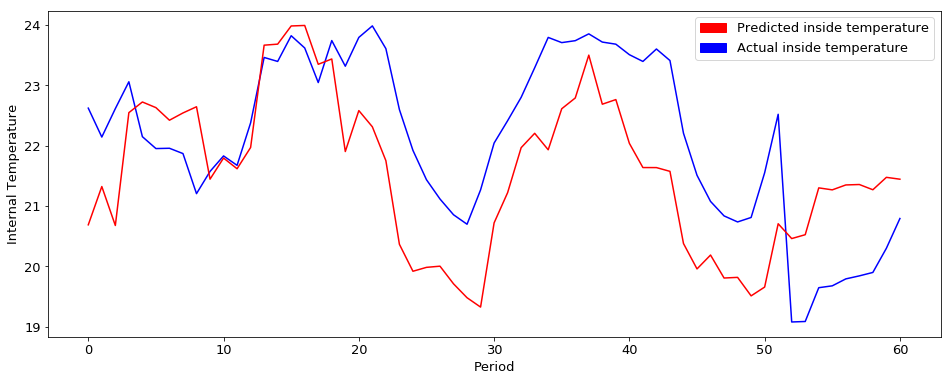

In [57]:
from pygam import LinearGAM, PoissonGAM, GammaGAM, GAM
from pygam.utils import generate_X_grid
import matplotlib.patches as mpatches

# Test for optimal number of splines
# score = 0
# splines = 0
# for i in range(10,200):
#     gam = LinearGAM(n_splines=i).gridsearch(X_train, y_train)
#     if score > gam.statistics_['pseudo_r2']['explained_deviance']:
#         score = max(score, gam.statistics_['pseudo_r2']['explained_deviance'])
#         splines = i
# print(score)
# print(splines)

gam = LinearGAM(n_splines=60).gridsearch(X_train, y_train)

# testing it on unseen data
x_period_test = np.arange(len(df_test['ts']))
third = len(x_period_test)//3


# plot GAM predicted results
plt.plot(x_period_test[:third//3], y_test[:third//3], 'b-', x_period_test[:third//3], gam.predict(X_test)[:third//3], 'r-')
# plt.title("Predicted Internal Temperature (May)")
plt.ylabel("Internal Temperature")
plt.xlabel("Period")
red_patch = mpatches.Patch(color='red', label='Predicted inside temperature')
blue_patch = mpatches.Patch(color='blue', label='Actual inside temperature')
plt.legend(handles=[red_patch, blue_patch])
plt.savefig("../plots/gam_result.png")
plt.show()

#### Model Results

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

gam.summary()
# pdeps = gam.partial_dependence(X_train)
# plt.plot(pdeps)


# mse = mean_squared_error(y_test, gam.predict(X_test))
mae = mean_absolute_error(y_test, gam.predict(X_test))
# rmse = np.sqrt(mse)
# print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)

Model Statistics
-----------------
edof       74.465
AIC      3859.805
AICc     3869.238
GCV         1.198
scale       1.075

Pseudo-R^2
----------------------------
explained_deviance     0.731
MAE: 1.253


E:\Anaconda3\envs\dsci\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-08-14 17:44:02.695177. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


$R^2 = 0.73$

$MAE = 1.25$

### Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(n_estimators=300, random_state=0)
rf_regressor.fit(X_train, y_train)

plt.plot(x_period_test, y_test, 'b-', x_period_test, rf_regressor.predict((X_test)), 'r-') # actual internal temp readings in blue
plt.title("Predicted Internal Temperature (May)")
plt.ylabel("Internal Temperature")
plt.xlabel("Period")
red_patch = mpatches.Patch(color='red', label='Predicted inside temperature')
blue_patch = mpatches.Patch(color='blue', label='Actual inside temperature')
plt.legend(handles=[red_patch, blue_patch])
plt.show()


## Model Validation


In [ ]:
# Linear Regression Model Evaluation
scores = cross_val_score(linear_regression, df.iloc[:,1:-1], df.iloc[:,-1], cv=5)
print("Linear Regression Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Decision Tree
scores = cross_val_score(dt_regressor, df.iloc[:,1:-1], df.iloc[:,-1], cv=5)
print("Decision Tree Regression Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Random Forest
scores = cross_val_score(rf_regressor, df.iloc[:,1:-1], df.iloc[:,-1], cv=5)
print("Random Forest Regression Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

35% Accuracy on the linear regression model isn't bad; considering that it measures exact match. When elbow room is given (within 0.8 degrees of accuracy):

In [ ]:
results = linear_regression.predict(X_test)
m = abs(results - y_test)

sensitivity = 0.8

total = m.shape[0]
approx_correct = m[abs(m) > sensitivity].shape[0]

print(approx_correct/total)

## Conclusion

The approximate accuracy of the best performing model (the linear regression) within 0.8 degrees Celsius is close to the R-Squared Error of the model at 0.57. This indicates that the model does not explain internal temperature to a significant (95%) degree. It is worth considering other factors that might add weight to the model's predictive ability.